# Balancing Walk Design

[![Contributor Covenant](https://img.shields.io/badge/Contributor%20Covenant-2.1-4baaaa.svg)](code_of_conduct.md)
[![deploy](https://github.com/ddimmery/balancer-package/actions/workflows/ci.yml/badge.svg)](https://github.com/ddimmery/balancer-package/actions/workflows/ci.yml)
[![DOI](https://zenodo.org/badge/493411416.svg)](https://zenodo.org/badge/latestdoi/493411416)
![PyPI](https://img.shields.io/pypi/v/bwd)

This package provides a reference implementation of the [Balancing Walk Design](https://arxiv.org/abs/2203.02025). It relies on minimal dependencies and is intended to be an easy way to plug in advanced experimental designs into existing systems with little overhead.

More details on the design of the method on the [About page](https://ddimmery.github.io/balancer-package/about/) and in the [paper](https://arxiv.org/abs/2203.02025). An [example of usage is below](#usage).

## Installation

With `pip`:

```
pip install bwd
```


## Usage

A simple example of how to use [BWD](https://ddimmery.github.io/balancer-package/reference/balancer/bwd/) to balance a stream of covariate data follows:

In [1]:
from bwd import BWD
from numpy.random import default_rng
import numpy as np
rng = default_rng(2022)

n = 10000
d = 5
ate = 1
beta = rng.normal(size = d)

X = rng.normal(size = (n, d))

balancer = BWD(N = n, D = d)
A_bwd = []
A_rand = []
imbalance_bwd = np.array([[0] * d])
imbalance_rand = np.array([[0] * d])

increment_imbalance = lambda imba, a, x: np.concatenate([imba, imba[-1:, :] + (2 * a - 1) * x])

for x in X:
    # Assign with BWD
    a_bwd = balancer.assign_next(x)
    imbalance_bwd = increment_imbalance(imbalance_bwd, a_bwd, x)
    A_bwd.append(a_bwd)
    # Assign with Bernoulli randomization
    a_rand = rng.binomial(n = 1, p = 0.5, size = 1).item()
    imbalance_rand = increment_imbalance(imbalance_rand, a_rand, x)
    A_rand.append(a_rand)

# Outcomes are only realized at the conclusion of the experiment
eps = rng.normal(size=n)
Y_bwd = X @ beta + A_bwd * ate + eps
Y_rand = X @ beta + A_rand + ate + eps

We can see how imbalance progresses as a function of time:

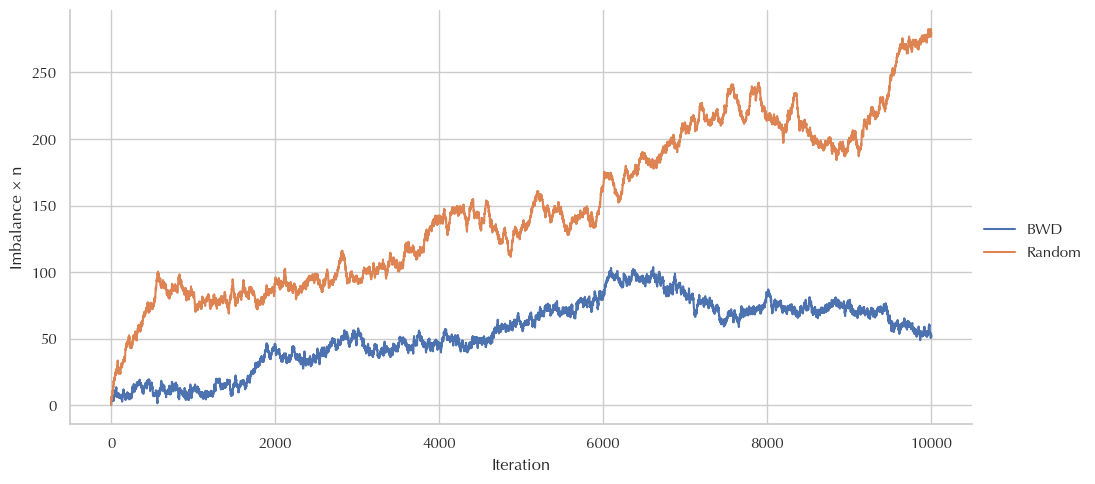

In [2]:
import seaborn as sns

norm_bwd = np.linalg.norm(imbalance_bwd, axis = 1).tolist()
norm_rand = np.linalg.norm(imbalance_rand, axis = 1).tolist()

sns.set_theme(style="whitegrid")
plt = sns.relplot(
    x=list(range(n + 1)) * 2, y=norm_bwd + norm_rand,
    hue = ["BWD"] * (n + 1) + ["Random"] * (n + 1),
    kind="line", height=5, aspect=2,
).set_axis_labels("Iteration", "Imbalance × n");
plt;

It's clear from the above chart that using BWD keeps imbalance substantially more under control than standard methods of randomization.

## Citation
#### APA
> Arbour, D., Dimmery, D., Mai, T. & Rao, A.. (2022). Online Balanced Experimental Design. *Proceedings of the 39th International Conference on Machine Learning*, in *Proceedings of Machine Learning Research* 162:844-864 Available from https://proceedings.mlr.press/v162/arbour22a.html.

#### BibTeX
```

@InProceedings{arbour2022online,
  title = 	 {Online Balanced Experimental Design},
  author =       {Arbour, David and Dimmery, Drew and Mai, Tung and Rao, Anup},
  booktitle = 	 {Proceedings of the 39th International Conference on Machine Learning},
  pages = 	 {844--864},
  year = 	 {2022},
  editor = 	 {Chaudhuri, Kamalika and Jegelka, Stefanie and Song, Le and Szepesvari, Csaba and Niu, Gang and Sabato, Sivan},
  volume = 	 {162},
  series = 	 {Proceedings of Machine Learning Research},
  month = 	 {17--23 Jul},
  publisher =    {PMLR},
  pdf = 	 {https://proceedings.mlr.press/v162/arbour22a/arbour22a.pdf},
  url = 	 {https://proceedings.mlr.press/v162/arbour22a.html},
}

```